## 1. Setup and Preprocessing

In [1]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [3]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("CUDA is not available. Using CPU.")

check_cuda()

CUDA is available. Using GPU: NVIDIA A100-SXM4-40GB


In [4]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [5]:
#  !pip install evaluate

In [6]:
#  !pip install -U bitsandbytes

In [7]:
# exit()

In [8]:
# !apt-get install -y ninja-build

In [9]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
import os


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login

In [10]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory to the NLP folder in your Drive
nlp_folder = Path('/content/drive/My Drive/NLP')
os.chdir(nlp_folder)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path (now the NLP folder)
basepath = nlp_folder

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder'
model_folder = Path(basepath) / 'lect 7' / 'assignment 7'/ 'sentiment' / 'nn' # Updated path
custom_functions = Path(basepath) / 'lect 7' / 'assignment 7' /'CustomFiles'  # Updated path

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/NLP
Model folder created: True
Custom functions folder created: True


In [11]:
set_seed(69)

In [12]:
model_folder.mkdir(exist_ok=True, parents = True)

In [13]:
import wandb

# Log into WandB
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shobhit-pachauri (shobhit-pachauri-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


True

In [14]:
from huggingface_hub import login

login()

In [48]:
model_folder

PosixPath('/content/drive/My Drive/NLP/lect 7/assignment 7/sentiment/nn')

In [49]:
import pandas as pd
import numpy as np
train_dataset = pd.read_csv(data_folder /'train.csv',usecols=lambda column: column != 'ID')

In [50]:
type(train_dataset)

pandas.core.frame.DataFrame

In [51]:
train_dataset.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [52]:
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [53]:
len(label_columns)

11

In [54]:
selected_columns = {
    'text': train_dataset['Tweet'],
    'label': train_dataset[label_columns].values.tolist()}

tweet_selected_columns = Dataset.from_dict(selected_columns)

In [55]:
tweet_selected_columns.set_format(type='pandas')

In [56]:
df = tweet_selected_columns[:]

In [57]:
df

,text,label
0,“Worry is a down payment on a problem you may ...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
7720,Excited to watch #stateoforigin tonight! Come ...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
7722,#ThingsIveLearned The wise #shepherd never tru...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [58]:
df_final = Dataset.from_pandas(df)

In [59]:
df_final

Dataset({
    features: ['text', 'label'],
    num_rows: 7724
})

In [60]:
test_val_splits = df_final.train_test_split(test_size=0.3, seed=36)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=36)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

In [61]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [62]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1159
    })
})

## 2. Tokenization

In [63]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [64]:
free_gpu_memory()

GPU memory has been freed.


In [65]:
checkpoint = "BAAI/bge-base-en"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [66]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [67]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [68]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1159
    })
})

In [69]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [70]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 1159
    })
})

In [71]:
tokenized_dataset['train']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## 3. Model Download

In [72]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [73]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [74]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [75]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
config.id2label = id2label
config.label2id = label2id
model.config = config

## 4. PEFT Setup

In [77]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [78]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [79]:
find_linear_layers(model)

['query', 'key', 'value', 'dense', 'dense', 'dense', 'dense', 'classifier']


['dense', 'key', 'query', 'classifier', 'value']

In [100]:
for name, module in model.named_modules():
    print(name, module)

 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [99]:
for name, module in model.named_modules():
    print(name, module)

 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [101]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                 # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",         # NormalFloat (nf4) quantization type for QLoRA
    bnb_4bit_use_double_quant=True     # Double quantization for additional memory efficiency
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['query', 'key', 'value', 'dense']  # Targeting specific modules within attention and output layers
)
lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 21,541,643 || all params: 130,929,430 || trainable%: 16.4529


In [102]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                     

In [103]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

base_model.model.bert.embeddings.word_embeddings.weight: False
base_model.model.bert.embeddings.position_embeddings.weight: False
base_model.model.bert.embeddings.token_type_embeddings.weight: False
base_model.model.bert.embeddings.LayerNorm.weight: False
base_model.model.bert.embeddings.LayerNorm.bias: True
base_model.model.bert.encoder.layer.0.attention.self.query.base_layer.weight: False
base_model.model.bert.encoder.layer.0.attention.self.query.base_layer.bias: True
base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight: True
base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default.weight: True
base_model.model.bert.encoder.layer.0.attention.self.key.base_layer.weight: False
base_model.model.bert.encoder.layer.0.attention.self.key.base_layer.bias: True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_A.default.weight: True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_B.default.weight: True
base_model.model.ber

## 5. Training and Validation

In [104]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [105]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/baai-bge")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'multilabel_tweet_hw7_gemma'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 69,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [106]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

BertConfig {
  "_name_or_path": "BAAI/bge-base-en",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype"

In [107]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [108]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [109]:
pos_weights

tensor([ 1.6882,  6.0945,  1.6487,  4.6489,  1.6896,  8.2568,  2.4433,  7.5538,
         2.3268, 17.3878, 18.1025])

In [110]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [111]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [112]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-112-205d00a764b3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [113]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.102800,1.081586,0.339129,0.191759,0.567731,0.000863
40,1.101200,1.079740,0.341917,0.195047,0.567025,0.000000
60,1.082100,1.076799,0.341423,0.195350,0.567888,0.000000
80,1.091800,1.074552,0.343312,0.202766,0.566397,0.000000
100,1.115200,1.072117,0.346977,0.215069,0.564515,0.000000
120,1.141300,1.069397,0.349416,0.238394,0.558946,0.000000
140,1.089000,1.066689,0.351466,0.274926,0.545533,0.000863
160,1.076500,1.063076,0.356058,0.294384,0.544356,0.000863
180,1.061400,1.059191,0.368736,0.307380,0.569221,0.002588
200,1.088300,1.055784,0.373086,0.315763,0.560044,0.002588


## 4. Validation

In [114]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [115]:
eval_results

{'eval_loss': 0.9202257394790649,
 'eval_f1_micro': 0.501105216622458,
 'eval_f1_macro': 0.4595739901795979,
 'eval_accuracy_label': 0.645933014354067,
 'eval_accuracy_all': 0.0008628127696289905,
 'eval_runtime': 2.831,
 'eval_samples_per_second': 409.389,
 'eval_steps_per_second': 13.069,
 'epoch': 2.0}

In [116]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [117]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [118]:
valid_logits.shape

(1159, 11)

## 5. Optimizing Thresholds and Accounting for Imbalance

In [119]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [120]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [121]:
optimal_thresholds

[0.5150711536407471,
 0.44263654947280884,
 0.5727225542068481,
 0.547947883605957,
 0.5994851589202881,
 0.7154240012168884,
 0.4622303247451782,
 0.5748721957206726,
 0.46587347984313965,
 0.5827285051345825,
 0.6477982401847839]

In [122]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [123]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.5858272162619989,
 'f1_macro': 0.5014831880112737,
 'accuracy_label': 0.7698643030825947,
 'accuracy_all': 0.03968938740293356}

## 6. Confusion Matrix

In [124]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 501  231]
  [  60  367]]

 [[ 517  477]
  [  45  120]]

 [[ 523  203]
  [  78  355]]

 [[ 800  157]
  [ 107   95]]

 [[ 629   96]
  [  83  351]]

 [[ 903  131]
  [  43   82]]

 [[ 558  225]
  [  54  322]]

 [[ 804  226]
  [  52   77]]

 [[ 437  394]
  [  55  273]]

 [[1034   73]
  [  33   19]]

 [[1034   72]
  [  39   14]]]


In [125]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

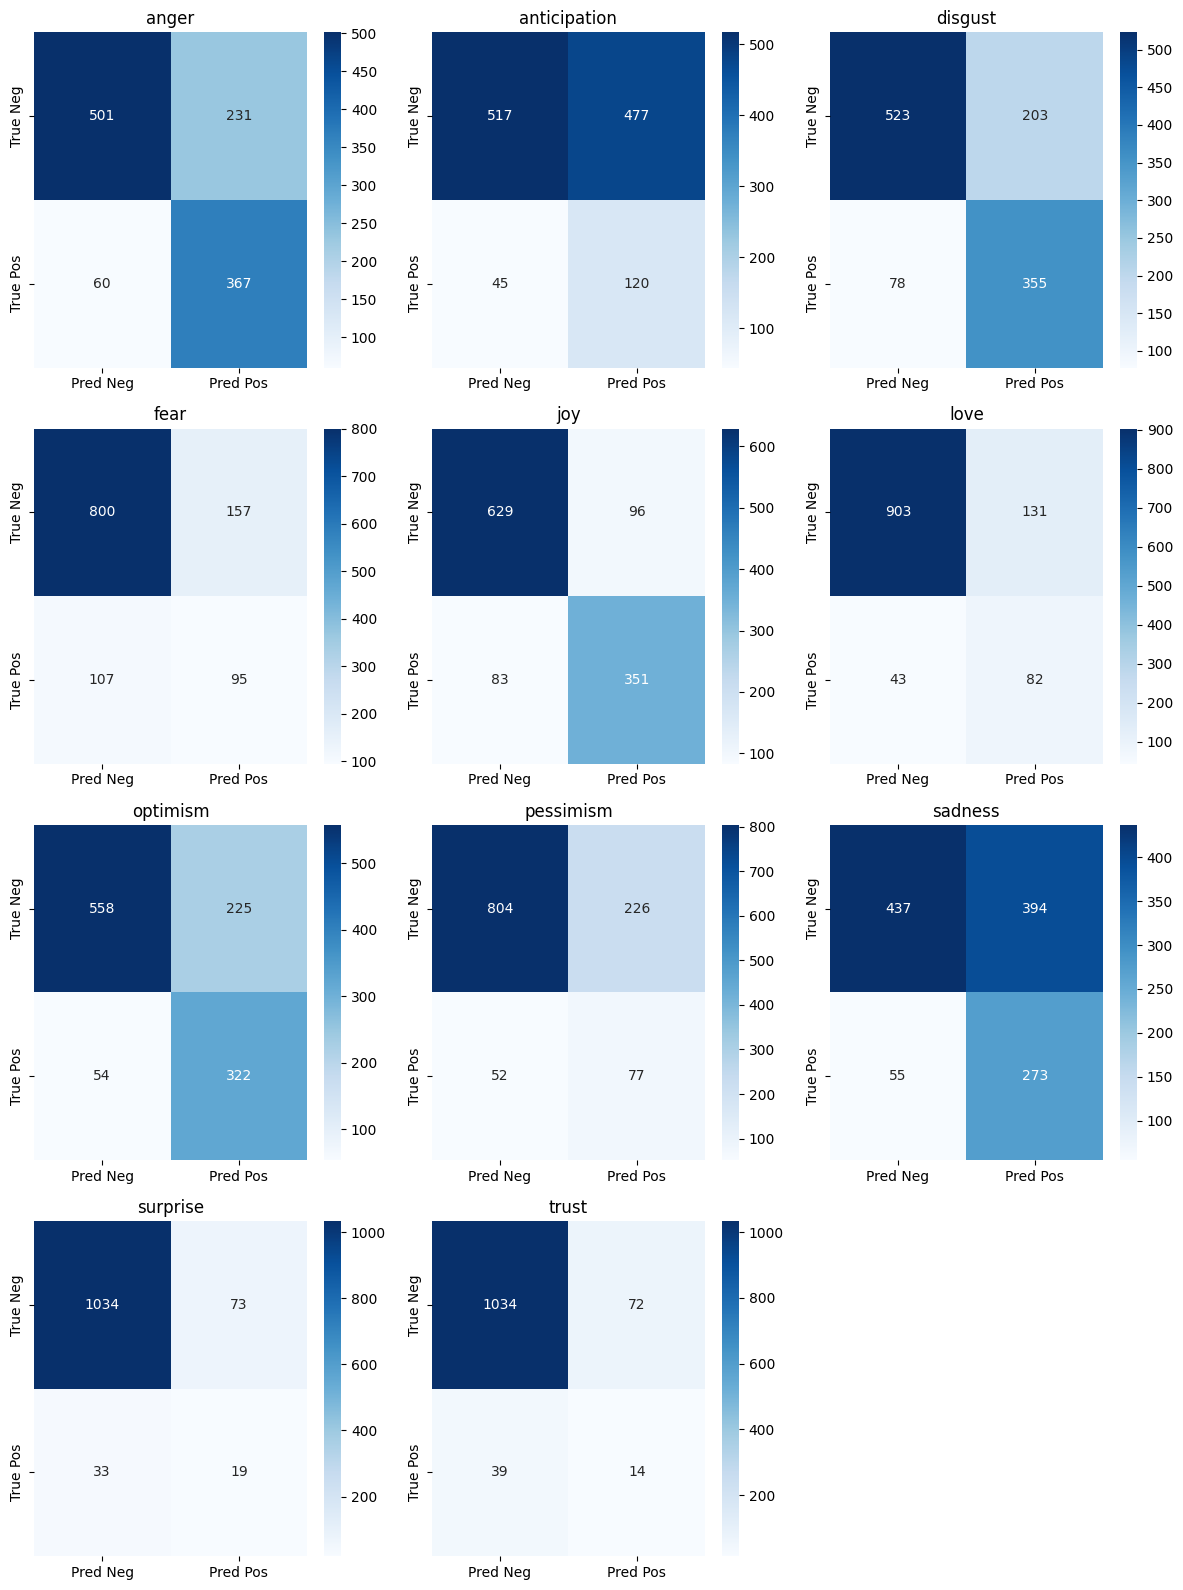

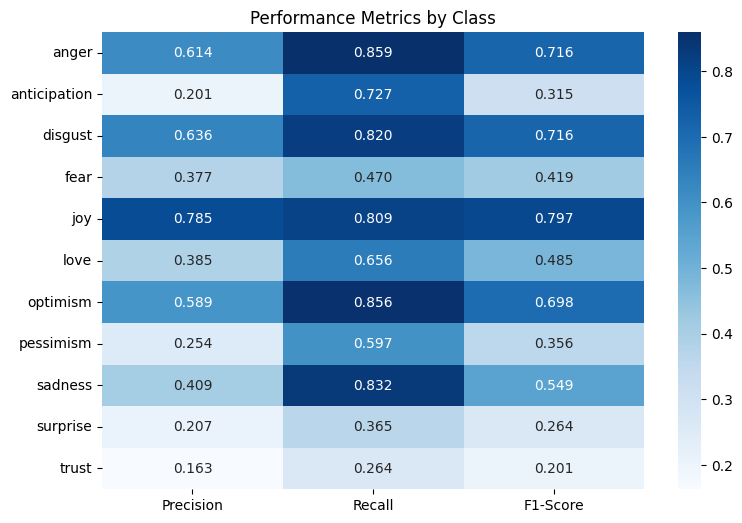

<Figure size 1200x533.333 with 0 Axes>

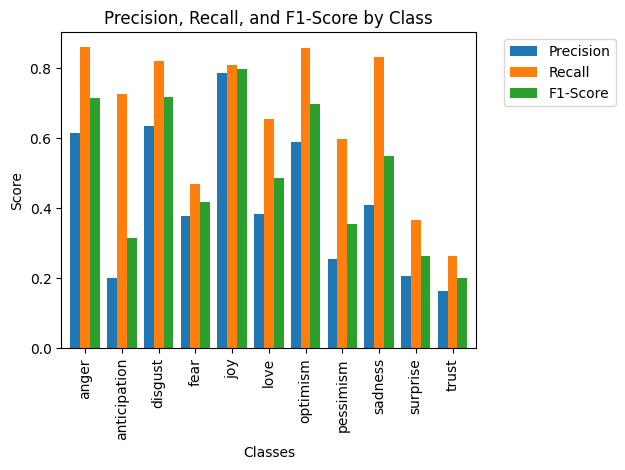

{'macro_avg': {'precision': 0.4199556652959634,
  'recall': 0.6597096874739795,
  'f1': 0.5014831880112737},
 'per_class': {'Precision': {'anger': 0.6137123745819398,
   'anticipation': 0.20100502512562815,
   'disgust': 0.6362007168458781,
   'fear': 0.376984126984127,
   'joy': 0.785234899328859,
   'love': 0.38497652582159625,
   'optimism': 0.5886654478976234,
   'pessimism': 0.25412541254125415,
   'sadness': 0.40929535232383807,
   'surprise': 0.20652173913043478,
   'trust': 0.16279069767441862},
  'Recall': {'anger': 0.8594847775175644,
   'anticipation': 0.7272727272727273,
   'disgust': 0.8198614318706697,
   'fear': 0.47029702970297027,
   'joy': 0.8087557603686636,
   'love': 0.656,
   'optimism': 0.8563829787234043,
   'pessimism': 0.5968992248062015,
   'sadness': 0.8323170731707317,
   'surprise': 0.36538461538461536,
   'trust': 0.2641509433962264},
  'F1-Score': {'anger': 0.7160975609756097,
   'anticipation': 0.31496062992125984,
   'disgust': 0.7164480322906155,
   '

In [126]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=label_columns, figsize=(12, 8))

## 7. Saving the Best Model

In [127]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 600.


In [128]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/baai-bge/checkpoint-600'

## 8. Performance on Test Set

In [129]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [130]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [132]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1159
})

In [133]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [134]:
training_args = TrainingArguments(
    seed = 69,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [135]:
from functools import partial
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [136]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-136-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [137]:
# !pip install accelerate - U

ERROR: Invalid requirement: '-': Expected package name at the start of dependency specifier
    -
    ^


In [138]:
# !pip install transformers -U

In [139]:
test_results= trainer.evaluate()

In [140]:
test_results

{'eval_loss': 0.9279983043670654,
 'eval_model_preparation_time': 0.0035,
 'eval_f1_micro': 0.5717894736842105,
 'eval_f1_macro': 0.490217438539676,
 'eval_accuracy_label': 0.7606871127147227,
 'eval_accuracy_all': 0.03537532355478861,
 'eval_runtime': 1.1149,
 'eval_samples_per_second': 1039.561,
 'eval_steps_per_second': 8.969}

In [141]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

In [142]:
test_output = trainer.predict(test_set_tokenized)

In [143]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))

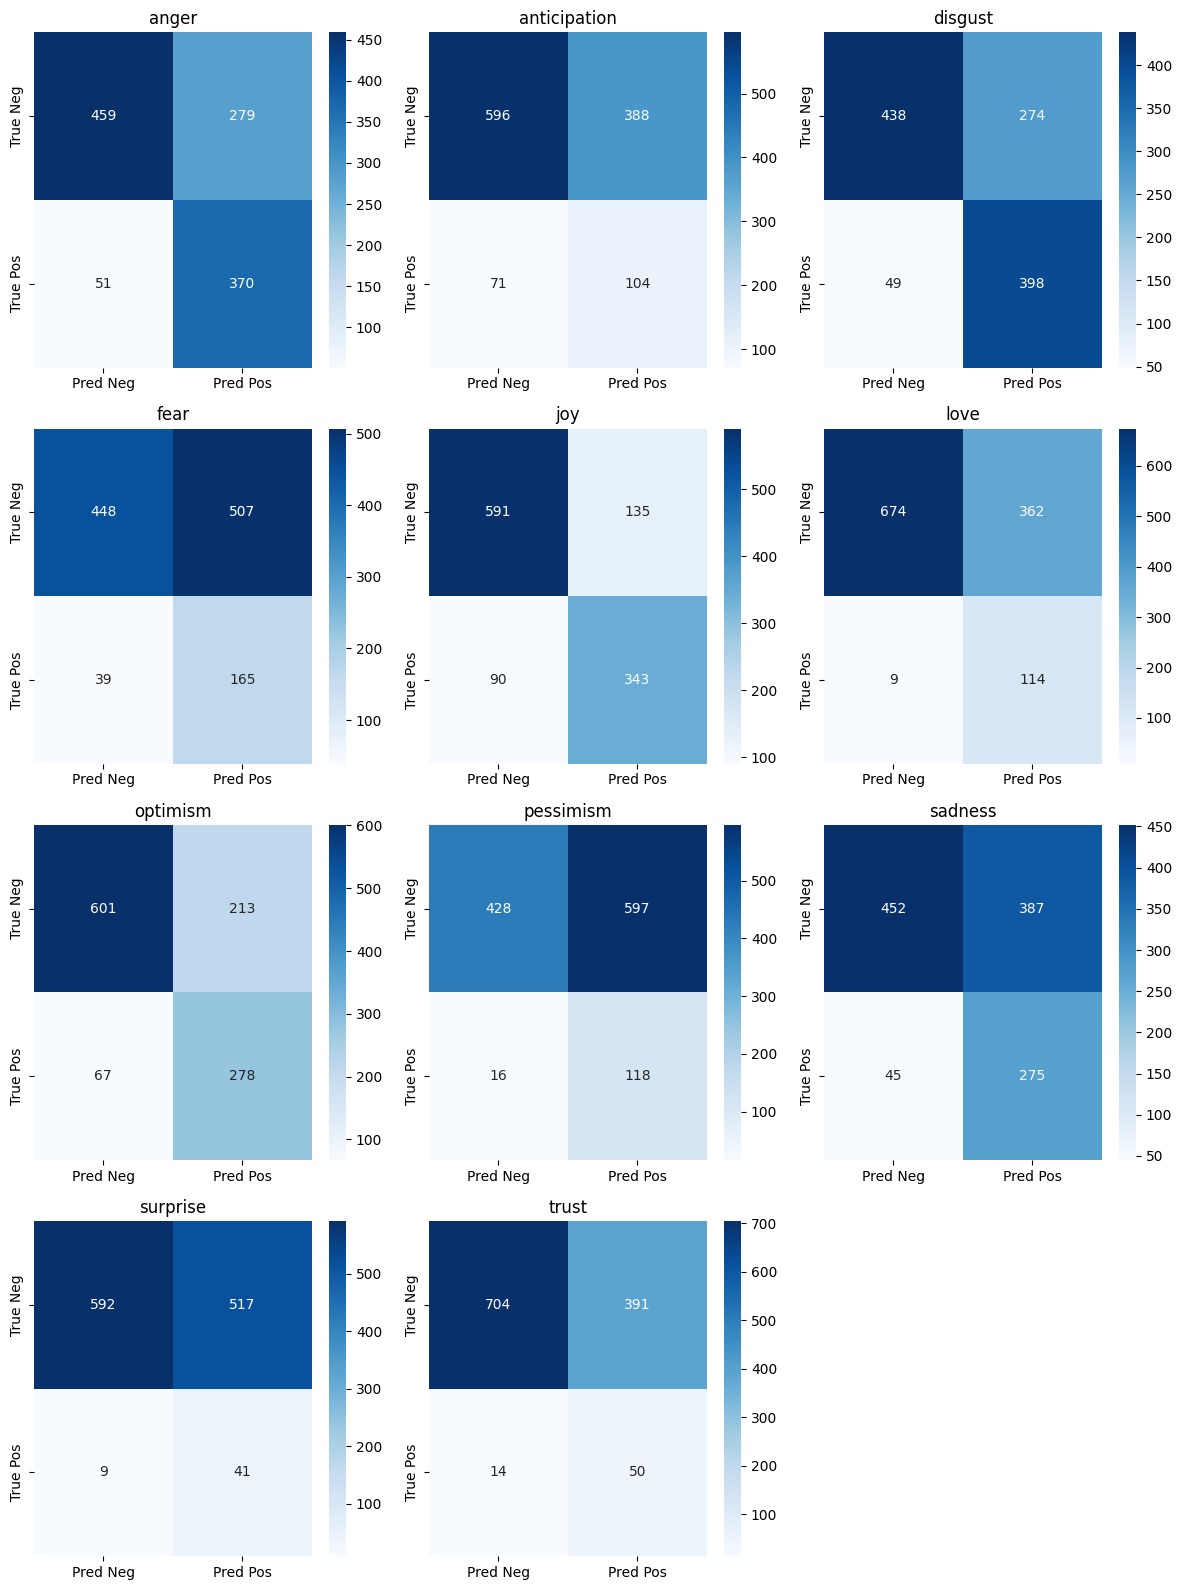

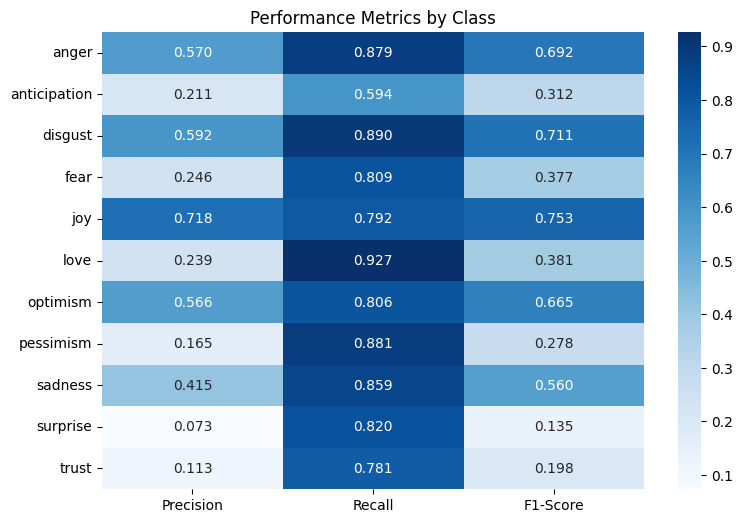

<Figure size 1200x533.333 with 0 Axes>

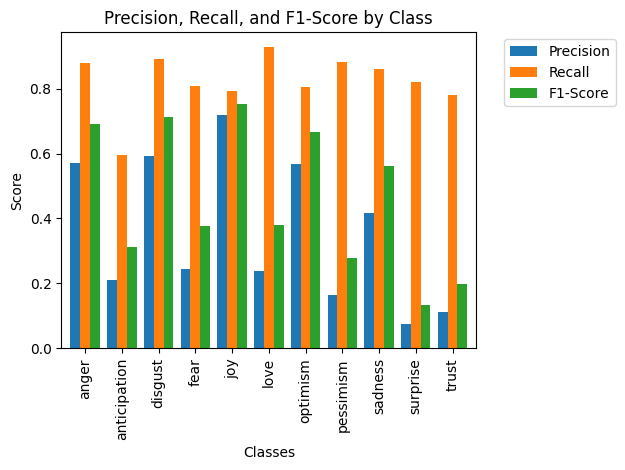

{'macro_avg': {'precision': 0.3554405695048589,
  'recall': 0.8216677822773382,
  'f1': 0.4601057462987914},
 'per_class': {'Precision': {'anger': 0.5701078582434514,
   'anticipation': 0.21138211382113822,
   'disgust': 0.5922619047619048,
   'fear': 0.24553571428571427,
   'joy': 0.7175732217573222,
   'love': 0.23949579831932774,
   'optimism': 0.5661914460285132,
   'pessimism': 0.16503496503496504,
   'sadness': 0.41540785498489424,
   'surprise': 0.07347670250896057,
   'trust': 0.11337868480725624},
  'Recall': {'anger': 0.8788598574821853,
   'anticipation': 0.5942857142857143,
   'disgust': 0.8903803131991052,
   'fear': 0.8088235294117647,
   'joy': 0.792147806004619,
   'love': 0.926829268292683,
   'optimism': 0.8057971014492754,
   'pessimism': 0.8805970149253731,
   'sadness': 0.859375,
   'surprise': 0.82,
   'trust': 0.78125},
  'F1-Score': {'anger': 0.6915887850467289,
   'anticipation': 0.3118440779610195,
   'disgust': 0.711349419124218,
   'fear': 0.3767123287671233

In [144]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_columns, figsize=(12, 8))

In [145]:
wandb.finish()

eval/accuracy_all,▁▁▁▁▁▁▁▁▁▁▁▁▅█▇▇█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy_label,▃▂▃▂▂▂▁▁▃▂▃▄▆▇█▆█▇█▇▇▆▇▇█▇██▇█████
eval/f1_macro,▁▁▁▁▂▂▃▄▄▄▅▅▆▇▇▇▇█████████████████
eval/f1_micro,▁▁▁▁▁▁▂▂▂▂▃▅▆▇▇▇▇▇██▇▇████████████
eval/loss,█████▇▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
eval/runtime,▄▄▁▁▄▂▁▅▂▃▃▁▂▆▃▃▃▄▃▃▄▂▂▅▃▁▄▄▁▂▄▃▂█
eval/samples_per_second,▅▅██▅▇█▄▇▆▆▇▆▃▆▆▆▅▆▆▅▇▇▄▆█▅▅█▇▅▆▇▁
eval/steps_per_second,▅▅██▅▇█▄▇▆▆▇▆▃▆▆▆▅▆▆▅▇▇▄▆█▅▅█▇▅▆▇▁
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


## 9. Model Inference

In [146]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [148]:
test_split['text'][0]

'#Spina #Bifida a #neural #tube #birth #defect where the #nervous #system &amp; #spinal #cord do not fully develop #raredisease #June #awareness'

In [149]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.5165954232215881},
  {'label': 'anticipation', 'score': 0.4634442627429962},
  {'label': 'disgust', 'score': 0.5827285051345825},
  {'label': 'fear', 'score': 0.5326682329177856},
  {'label': 'joy', 'score': 0.42298123240470886},
  {'label': 'love', 'score': 0.4063907563686371},
  {'label': 'optimism', 'score': 0.4258439540863037},
  {'label': 'pessimism', 'score': 0.5841525197029114},
  {'label': 'sadness', 'score': 0.5491571426391602},
  {'label': 'surprise', 'score': 0.523907482624054},
  {'label': 'trust', 'score': 0.39466747641563416}]]

In [150]:
def get_positive_labels(pipeline_output, threshold=0.5):

    positive_labels = []

    for pred_set in pipeline_output:
        # Get labels where score >= threshold
        sample_positives = [pred['label'] for pred in pred_set
                          if pred['score'] >= threshold]
        positive_labels.append(sample_positives)

    return positive_labels

In [151]:
results = get_positive_labels(preds, threshold=0.5)
results

[['anger', 'disgust', 'fear', 'pessimism', 'sadness', 'surprise']]

In [152]:
preds = custom_pipeline(test_split['text'], truncation=True)

In [153]:
preds[0:5]

[[{'label': 'anger', 'score': 0.5165954232215881},
  {'label': 'anticipation', 'score': 0.4634442627429962},
  {'label': 'disgust', 'score': 0.5827285051345825},
  {'label': 'fear', 'score': 0.5326682329177856},
  {'label': 'joy', 'score': 0.42298123240470886},
  {'label': 'love', 'score': 0.4063907563686371},
  {'label': 'optimism', 'score': 0.4258439540863037},
  {'label': 'pessimism', 'score': 0.5841525197029114},
  {'label': 'sadness', 'score': 0.5491571426391602},
  {'label': 'surprise', 'score': 0.523907482624054},
  {'label': 'trust', 'score': 0.39466747641563416}],
 [{'label': 'anger', 'score': 0.6749081611633301},
  {'label': 'anticipation', 'score': 0.3486451506614685},
  {'label': 'disgust', 'score': 0.6584175229072571},
  {'label': 'fear', 'score': 0.5474640727043152},
  {'label': 'joy', 'score': 0.2538610100746155},
  {'label': 'love', 'score': 0.2613309323787689},
  {'label': 'optimism', 'score': 0.27904197573661804},
  {'label': 'pessimism', 'score': 0.6141626238822937},

Testing

In [154]:
test = pd.read_csv(data_folder /'test.csv')
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [155]:
testset = Dataset.from_dict({
    'text': test['Tweet']})

In [156]:
testset

Dataset({
    features: ['text'],
    num_rows: 3259
})

## 10. Submission for Kaggle

In [157]:
tokenized__test_dataset= testset.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized__test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [158]:
predictions = trainer.predict(tokenized_test_dataset)
predictions

PredictionOutput(predictions=array([[ 0.84765625, -0.484375  ,  0.53125   , ...,  0.60546875,
        -0.41992188, -0.50390625],
       [ 0.77734375, -0.53125   ,  0.69921875, ...,  0.80859375,
        -0.12890625, -0.796875  ],
       [ 0.8984375 , -0.546875  ,  0.68359375, ...,  0.734375  ,
        -0.35351562, -0.6640625 ],
       ...,
       [ 0.984375  , -0.59765625,  0.640625  , ...,  0.76171875,
        -0.28710938, -0.66796875],
       [-1.1171875 ,  0.46679688, -0.66015625, ..., -0.78125   ,
         0.24121094,  0.60546875],
       [-1.140625  ,  0.49609375, -0.65625   , ..., -0.71875   ,
         0.25390625,  0.5703125 ]], dtype=float32), label_ids=None, metrics={'test_model_preparation_time': 0.0035, 'test_runtime': 1.8695, 'test_samples_per_second': 1743.29, 'test_steps_per_second': 13.908})

In [159]:
predictions_test = pd.DataFrame((predictions.predictions > 0).astype(int), columns=label_columns)
predictions_test

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,0,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,0,1,1,0,0
2,1,0,1,1,0,0,0,1,1,0,0
3,0,1,0,0,1,1,1,0,0,1,1
4,1,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,1,0,0,0,1,1,0,0
3255,0,0,1,1,0,0,0,1,1,1,0
3256,1,0,1,1,0,0,0,1,1,0,0
3257,0,1,0,0,1,1,1,0,0,1,1


In [160]:
submission = pd.concat([test['ID'], predictions_test], axis=1)

In [161]:
submission.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,1,1,0,0
1,2018-03739,1,0,1,1,0,0,0,1,1,0,0
2,2018-00385,1,0,1,1,0,0,0,1,1,0,0
3,2018-03001,0,1,0,0,1,1,1,0,0,1,1
4,2018-01988,1,0,1,1,0,0,0,1,1,0,0


In [165]:
submission.to_csv('baai-bge.csv', index = False)

In [166]:
from google.colab import files

files.download('baai-bge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>